In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

ورژن تنسورفلو موجود در کولب باید تغییر داده شود، بنابراین به همین علت از آخرین خط در بلوک بالا استفاده شده است.

##Loading data 
در این بخش داده ها لود می شوند و فرآیند نرمال سازی بر روی آن ها صورت می گیرد

In [2]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

 داده ورودی به شبکه باید 3 بعد داشته باشد، به همین خاطر یک بعد به ایکس ترین اضافه می کنیم.
اضافه کردن این بعد همانند این است که یک عکس خاکستری داشته باشیم، به جای 3 کانال رنگ تنها 1 کانال رنگ داریم(سیاه و سفید)

In [3]:
x_train = np.expand_dims(x_train,axis=-1)  #expanding dimesnion
x_test = np.expand_dims(x_test,axis=-1) #expanding dimesnion
x_train=x_train.astype('float32')/255  #Normalization
x_test=x_test.astype('float32')/255 #Normalization
y_train=y_train.astype('float32')

In [4]:
y_test2 = y_test.copy()

In [5]:
x_train.shape

(60000, 28, 28, 1)

# Varitional Auto Encoder (VAE)


In [6]:
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Conv2D,Flatten,ReLU,Dropout,UpSampling2D,Embedding,Concatenate,Conv2DTranspose
from keras.layers import Reshape,MaxPool2D
#from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras import backend as bk 
from keras.layers import Lambda

##Encoder part

In [7]:
def sample(inp):
  mu , var = inp
  epslion = bk.random_normal(shape=(bk.shape(mu)[0],bk.shape(mu)[1]))
  samp = mu + bk.exp(var/2)*epslion
  return samp

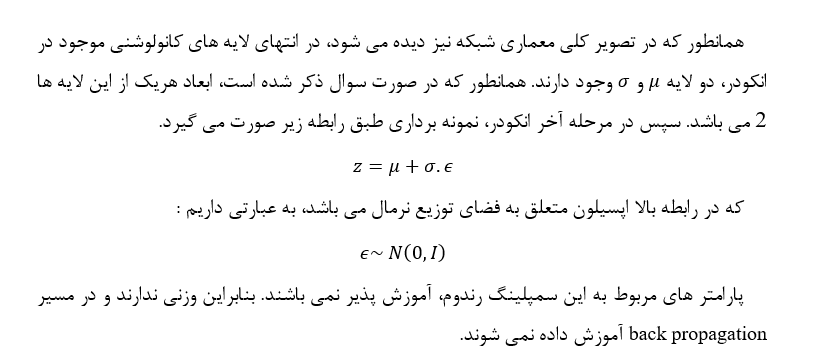

In [8]:
network_input = Input(shape=(28,28,1))

encoder = Conv2D(16, (4,4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(network_input)
encoder = Conv2D(32, (4,4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(encoder)
#encoder = Conv2D(64, (4, 4),activation='relu',kernel_initializer='he_uniform',  padding='same')(encoder)

encoder = Conv2D(64, (4,4),activation='relu',kernel_initializer='he_uniform',  padding='same')(encoder)

encoder = Flatten()(encoder)
encoder = Dense(32 , activation='relu')(encoder)

mu_e = Dense(2)(encoder) # 2 is the latent space dimension
var_e = Dense(2)(encoder)

z = Lambda(sample,output_shape=(2,))([mu_e,var_e])

encoder_network = Model(network_input,[mu_e,var_e,z])


In [9]:
encoder_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 16)   272         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 32)     8224        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     32832       conv2d_1[0][0]                   
______________________________________________________________________________________________

##Decoder

In [10]:
decoder_inp = Input(shape=(2,))

decoder = Dense(7*7*128,activation='relu')(decoder_inp)
decoder = Reshape((7,7,128))(decoder)

decoder = Conv2DTranspose(64,(4,4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(decoder)
#decoder =Conv2DTranspose(64,(4, 4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(decoder)
decoder =Conv2DTranspose(32,(4,4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',padding='same')(decoder)
decoder =Conv2DTranspose(16,(4,4),activation='relu',kernel_initializer='he_uniform',padding='same')(decoder)
decoder = Conv2DTranspose(1,(4,4),activation='relu',kernel_initializer='he_uniform',padding='same')(decoder)

decoder_network = Model(decoder_inp,decoder)

In [11]:
decoder_network.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        131136    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        32800     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 16)        8208      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         257 

## End To End Network

In [12]:
encod = encoder_network(network_input)[2]
decod = decoder_network(encod)
vae = Model(network_input,decod)

In [13]:
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           [(None, 2), (None, 2), (N 141844    
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         191217    
Total params: 333,061
Trainable params: 333,061
Non-trainable params: 0
_________________________________________________________________


## Loss function

توضیحات مربوط به تابع لاس مورد استفاده

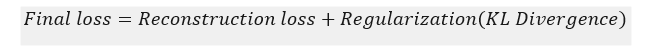

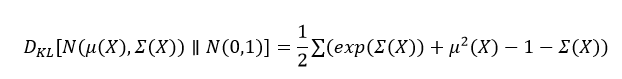

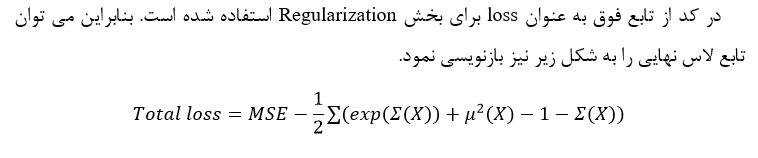

In [14]:
def network_loss(mu,var):
  def normal_ae_loss(y_true,y_pred):
    return tf.reduce_mean(tf.keras.metrics.mse(y_true,y_pred))*28*28
  def kl_divergence(mu,var):
    return 0.5*tf.reduce_mean(-1-var+tf.square(mu)+tf.exp(var))
  def final_loss(y_true,y_pred):
    return bk.mean(normal_ae_loss(y_true, y_pred) + kl_divergence(mu,var))

  return final_loss

##Trainig

با توجه به جستجو های صورت گرفته،بهینه ساز مورد استفاده  در بسیاری از شبکه های گن به صورت زیر می باشد. به طور مثال در وسال دوم همین مینی پروژه نیز از بهینه ساز اشاره شده استفاده شده است.

Adam / Learning rate  =0.0002 / Beta_1 = 0.5

In [14]:
opt = Adam(lr = 0.0002,beta_1=0.5)
vae.compile(loss=network_loss(mu_e, var_e), optimizer=opt)

 از قطعه کد زیر به منظور ایجاد تصاویر بعد از هر 10 ایپاک استفاده شده است. به کمک این قطعه کد می توان روند تکامل عکس ها را مشاهده نمود.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


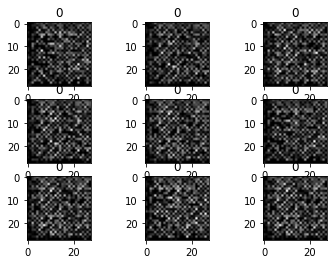

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 130us/sample - loss: 44.2609 - val_loss: 40.3915
Epoch 2/10
48000/48000 [==============================] - 6s 119us/sample - loss: 39.4849 - val_loss: 38.2955
Epoch 3/10
48000/48000 [==============================] - 6s 120us/sample - loss: 37.9765 - val_loss: 37.6335
Epoch 4/10
48000/48000 [==============================] - 6s 121us/sample - loss: 37.0936 - val_loss: 36.6788
Epoch 5/10
48000/48000 [==============================] - 6s 125us/sample - loss: 36.4705 - val_loss: 35.9201
Epoch 6/10
48000/48000 [==============================] - 6s 126us/sample - loss: 36.0100 - val_loss: 35.5527
Epoch 7/10
48000/48000 [==============================] - 6s 122us/sample - loss: 35.6214 - val_loss: 35.3930
Epoch 8/10
48000/48000 [==============================] - 6s 124us/sample - loss: 35.3153 - val_loss: 35.2955
Epoch 9/10
48000/48000 [==============================] - 6s 121us/sam

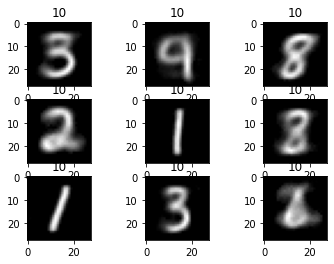

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 124us/sample - loss: 34.5658 - val_loss: 34.7359
Epoch 2/10
48000/48000 [==============================] - 6s 122us/sample - loss: 34.3979 - val_loss: 34.3931
Epoch 3/10
48000/48000 [==============================] - 6s 128us/sample - loss: 34.2220 - val_loss: 34.8076
Epoch 4/10
48000/48000 [==============================] - 6s 127us/sample - loss: 34.0568 - val_loss: 34.3596
Epoch 5/10
48000/48000 [==============================] - 6s 127us/sample - loss: 33.9038 - val_loss: 34.1055
Epoch 6/10
48000/48000 [==============================] - 6s 125us/sample - loss: 33.7488 - val_loss: 34.0869
Epoch 7/10
48000/48000 [==============================] - 6s 126us/sample - loss: 33.6139 - val_loss: 34.0016
Epoch 8/10
48000/48000 [==============================] - 6s 126us/sample - loss: 33.4961 - val_loss: 33.9627
Epoch 9/10
48000/48000 [==============================] - 6s 120us/sam

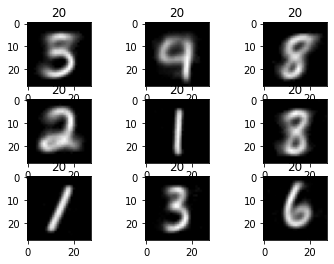

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 128us/sample - loss: 33.1994 - val_loss: 33.8525
Epoch 2/10
48000/48000 [==============================] - 6s 123us/sample - loss: 33.0895 - val_loss: 33.9325
Epoch 3/10
48000/48000 [==============================] - 6s 126us/sample - loss: 32.9918 - val_loss: 33.5842
Epoch 4/10
48000/48000 [==============================] - 6s 123us/sample - loss: 32.8890 - val_loss: 33.5185
Epoch 5/10
48000/48000 [==============================] - 6s 127us/sample - loss: 32.8139 - val_loss: 33.7888
Epoch 6/10
48000/48000 [==============================] - 6s 124us/sample - loss: 32.7354 - val_loss: 33.4415
Epoch 7/10
48000/48000 [==============================] - 6s 123us/sample - loss: 32.6677 - val_loss: 33.4482
Epoch 8/10
48000/48000 [==============================] - 6s 124us/sample - loss: 32.5910 - val_loss: 33.4619
Epoch 9/10
48000/48000 [==============================] - 6s 125us/sam

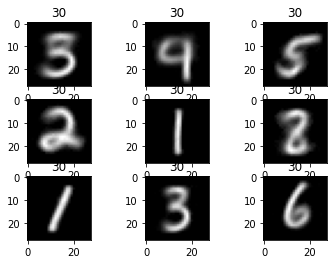

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 125us/sample - loss: 32.3836 - val_loss: 33.4125
Epoch 2/10
48000/48000 [==============================] - 6s 125us/sample - loss: 32.3158 - val_loss: 33.2523
Epoch 3/10
48000/48000 [==============================] - 6s 128us/sample - loss: 32.2608 - val_loss: 33.3501
Epoch 4/10
48000/48000 [==============================] - 6s 125us/sample - loss: 32.1995 - val_loss: 33.2503
Epoch 5/10
48000/48000 [==============================] - 6s 123us/sample - loss: 32.1369 - val_loss: 33.3305
Epoch 6/10
48000/48000 [==============================] - 6s 129us/sample - loss: 32.0883 - val_loss: 33.3815
Epoch 7/10
48000/48000 [==============================] - 6s 127us/sample - loss: 32.0280 - val_loss: 33.3299
Epoch 8/10
48000/48000 [==============================] - 6s 125us/sample - loss: 31.9973 - val_loss: 33.2721
Epoch 9/10
48000/48000 [==============================] - 6s 124us/sam

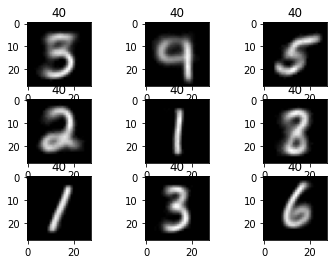

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 126us/sample - loss: 31.8409 - val_loss: 33.1334
Epoch 2/10
48000/48000 [==============================] - 6s 126us/sample - loss: 31.7971 - val_loss: 33.2411
Epoch 3/10
48000/48000 [==============================] - 6s 123us/sample - loss: 31.7516 - val_loss: 33.1473
Epoch 4/10
48000/48000 [==============================] - 6s 126us/sample - loss: 31.7098 - val_loss: 33.0980
Epoch 5/10
48000/48000 [==============================] - 6s 123us/sample - loss: 31.6598 - val_loss: 33.0834
Epoch 6/10
48000/48000 [==============================] - 6s 124us/sample - loss: 31.6353 - val_loss: 33.0966
Epoch 7/10
48000/48000 [==============================] - 6s 122us/sample - loss: 31.5907 - val_loss: 33.2617
Epoch 8/10
48000/48000 [==============================] - 6s 126us/sample - loss: 31.5485 - val_loss: 33.1293
Epoch 9/10
48000/48000 [==============================] - 6s 124us/sam

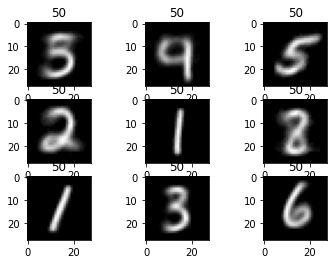

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 126us/sample - loss: 31.4357 - val_loss: 33.2744
Epoch 2/10
48000/48000 [==============================] - 6s 123us/sample - loss: 31.4078 - val_loss: 32.9651
Epoch 3/10
48000/48000 [==============================] - 6s 123us/sample - loss: 31.3650 - val_loss: 33.3750
Epoch 4/10
48000/48000 [==============================] - 6s 128us/sample - loss: 31.3403 - val_loss: 33.1771
Epoch 5/10
48000/48000 [==============================] - 6s 124us/sample - loss: 31.2963 - val_loss: 33.0103
Epoch 6/10
48000/48000 [==============================] - 6s 124us/sample - loss: 31.2710 - val_loss: 33.0268
Epoch 7/10
48000/48000 [==============================] - 6s 126us/sample - loss: 31.2505 - val_loss: 33.2808
Epoch 8/10
48000/48000 [==============================] - 6s 127us/sample - loss: 31.2033 - val_loss: 33.0967
Epoch 9/10
48000/48000 [==============================] - 6s 122us/sam

In [ ]:
for j in range(6):
  for i in range(9):
    plt.subplot(331+i)
    output = vae.predict(np.array([x_test[i+500]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.title(j*10)
  plt.show()
  histoy = vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_split = 0.2) # استفاده از این بخش برای ترسیم خروجی دیکودر در هر 10 ایپاک

از قطعه کد زیر برای ترسیم نمودار لاس (از ایپاک 0 تا ایپاک 50 ) استفاده شده است.

In [ ]:
history = vae.fit(x_train, x_train, epochs=50, batch_size=64, validation_split = 0.2) #از این بخش برای ترسیم نمودار لاس استفاده می کنیم، از بخش قبلی برای رسم کردن تصاویر خروجی دیکودر در هر 10 ایپاک 

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
47808/48000 [============================>.] - ETA: 0s - loss: 44.7042

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 9s 192us/sample - loss: 44.6920 - val_loss: 40.7794
Epoch 2/50
48000/48000 [==============================] - 6s 122us/sample - loss: 39.6316 - val_loss: 38.1611
Epoch 3/50
48000/48000 [==============================] - 6s 123us/sample - loss: 37.9719 - val_loss: 37.2452
Epoch 4/50
48000/48000 [==============================] - 6s 124us/sample - loss: 36.9415 - val_loss: 36.3319
Epoch 5/50
48000/48000 [==============================] - 6s 125us/sample - loss: 36.2063 - val_loss: 36.2676
Epoch 6/50
48000/48000 [==============================] - 6s 126us/sample - loss: 35.6313 - val_loss: 35.5001
Epoch 7/50
48000/48000 [==============================] - 6s 125us/sample - loss: 35.2330 - val_loss: 35.3336
Epoch 8/50
48000/48000 [==============================] - 6s 126us/sample - loss: 34.8465 - val_loss: 34.9452
Epoch 9/50
48000/48000 [==============================] - 6s 129us/sample - loss: 34.5630 - val_loss: 34.4891
Epoch 10/50
48000/480

Real Test Images


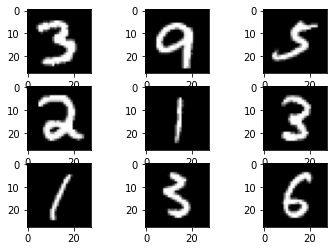

In [ ]:
for i in range(9):
    plt.subplot(331+i)
    plt.imshow(x_test[500+i,:,:, -1], cmap='gray')
plt.show()

## Scatter plot

In [ ]:
import pandas as pd
import seaborn as sns
def my_scatterplot(x_test,y_test):
  x = []
  y = []
  z = []
  for i in range(100*100):
    z.append(y_test[i]) #Real number coressponding to the input
    latent_space = encoder_network.predict(np.array([x_test[i]]))[2]
    x.append(latent_space[0][0])
    y.append(latent_space[0][1])
  datam = pd.DataFrame()
  datam['x'] = x
  datam['y'] = y
  zz = []
  for j in z:
    zz.append(str(j))
  datam['z'] = zz

  plt.figure(figsize=(8,8))
  sns.scatterplot(x='x', y='y', hue='z', data=datam)
  plt.show()
  return x,y

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


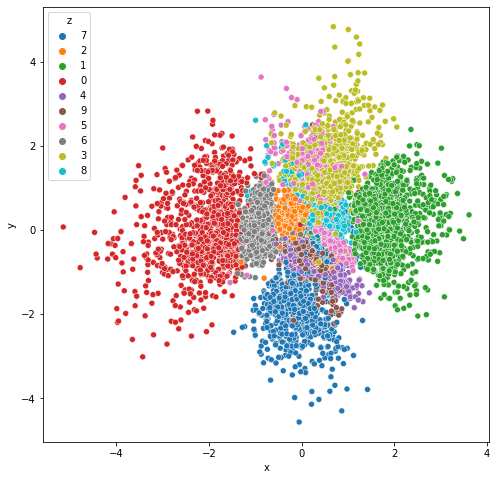

In [ ]:
z1,z2 = my_scatterplot(x_test,y_test)

مشخص کردن حدود پراکندگی داده ها در فضای لیتنت

In [ ]:
print(max(z1))
print(min(z1))
print("___________")
print(max(z2))
print(min(z2))

3.611616
-5.1495504
___________
4.830826
-4.5650043


## output of VAE Network

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


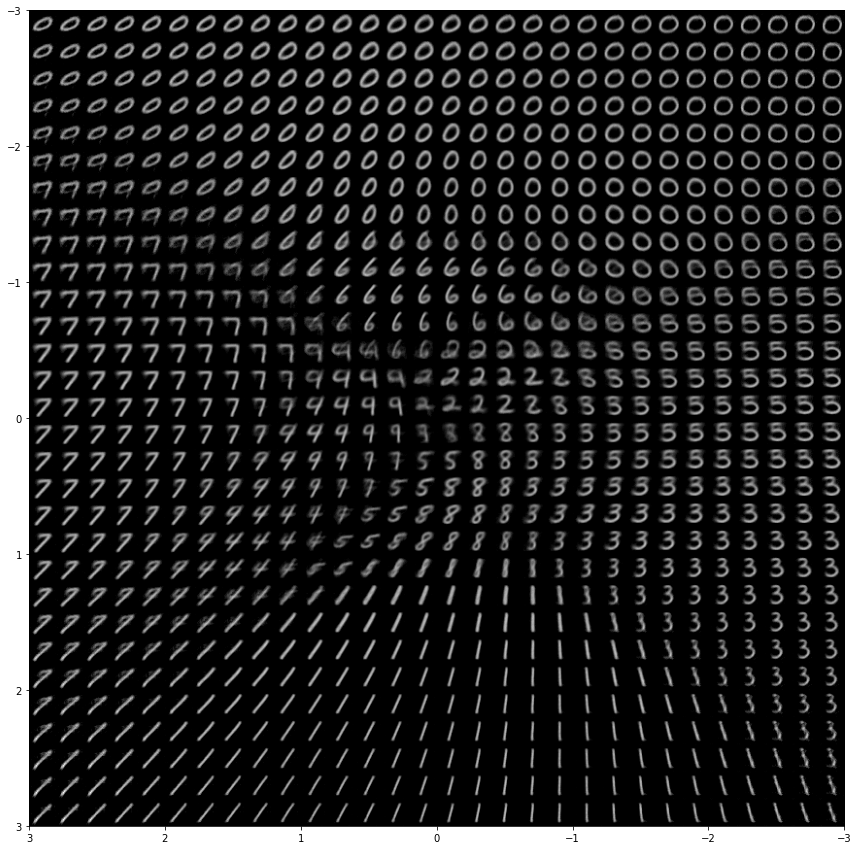

In [ ]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)
finalimg = np.zeros((28 * 30, 28 * 30))
for ix in range(len(x_values)):
    for iy in range(len(y_values)):
        latent_point = np.array([[x_values[ix], y_values[iy]]])
        network_out = decoder_network.predict(latent_point)[0]
        finalimg[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = network_out[:,:,-1]
 
plt.figure(figsize=(15, 15))
plt.imshow(finalimg, cmap='gray', extent=[3,-3,3,-3])
plt.show()

## loss plot

In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'],label='train_loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()

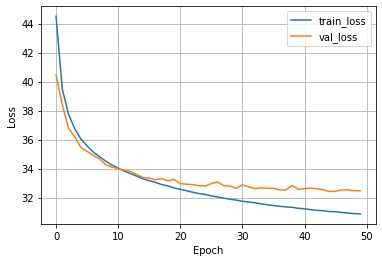

In [ ]:
plot_loss(history)

#CVAE


این شبکه همانند شبکه بخش قبل می باشد، با این تفاوت که لیبل ها هم به عنوان ورودی به شبکه داده می شوند.

In [16]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train=y_train.astype('float32')
y_test=y_test.astype('float32')

## Encoder & End-To-End Netwrok

In [17]:
from keras.layers.merge import concatenate 
label_input = Input(shape=(10,))
li = Dense(28*28*1)(label_input)
li = Reshape((28,28,1))(li)

image_input = Input(shape=(28,28,1))

network_input = concatenate([image_input,li])

encoder = Conv2D(16, (4,4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(network_input)
encoder = Conv2D(32, (4,4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',  padding='same')(encoder)
#encoder = Conv2D(64, (4, 4),activation='relu',kernel_initializer='he_uniform',  padding='same')(encoder)

encoder = Conv2D(64, (4,4),activation='relu',kernel_initializer='he_uniform',  padding='same')(encoder)

encoder = Flatten()(encoder)
encoder = Dense(32 , activation='relu')(encoder)

mu_e = Dense(2)(encoder) # 2 is the latent space dimension
var_e = Dense(2)(encoder)

z = Lambda(sample,output_shape=(2,))([mu_e,var_e])
decoder_input = concatenate([z, label_input])

decoder_h1 = Dense(7*7*128,activation='relu')
decoder_h2 = Reshape((7,7,128))

decoder_h3 = Conv2DTranspose(64,(4,4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')
#decoder =Conv2DTranspose(64,(4, 4),activation='relu',strides=(2,2),kernel_initializer='he_uniform',padding='same')(decoder)
decoder_h4 =Conv2DTranspose(32,(4,4),strides=(2,2),activation='relu',kernel_initializer='he_uniform',padding='same')
decoder_h5 =Conv2DTranspose(16,(4,4),activation='relu',kernel_initializer='he_uniform',padding='same')
decoder_h6  = Conv2DTranspose(1,(4,4),activation='relu',kernel_initializer='he_uniform',padding='same')

h = decoder_h1(decoder_input)
h = decoder_h2(h)
h = decoder_h3(h)
h = decoder_h4(h)
h = decoder_h5(h)
out = decoder_h6(h)


encoder_network = Model([image_input,label_input],z)
cvae = Model([image_input,label_input],out)


## Decoder Network

In [18]:
decoder_in = Input(shape=(12,))
d_1 = decoder_h1(decoder_in)
d_1 = decoder_h2(d_1)
d_1 = decoder_h3(d_1)
d_1 = decoder_h4(d_1)
d_1 = decoder_h5(d_1)
decoder_out = decoder_h6(d_1)
decoder_network = Model(decoder_in,decoder_out)

## Network Summary

In [19]:
decoder_network.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 6272)              81536     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        131136    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        32800     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 16)        8208      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         257 

In [20]:
encoder_network.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 784)          8624        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_4[0][0]                    
____________________________________________________________________________________________

In [21]:
cvae.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 784)          8624        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_4[0][0]                    
____________________________________________________________________________________________

##Trainig

In [22]:
opt = Adam(lr = 0.0002,beta_1=0.5)
cvae.compile(loss=network_loss(mu_e, var_e), optimizer=opt)

از قطعه کد زیر برای ترسیم نمودار لاس (از ایپاک 0 تا ایپاک 50 ) استفاده شده است.

In [23]:
cvae_history = cvae.fit([x_train,y_train], x_train, epochs=50, batch_size=64, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
47616/48000 [============================>.] - ETA: 0s - loss: 34.8485

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 9s 181us/sample - loss: 34.8059 - val_loss: 30.7469
Epoch 2/50
48000/48000 [==============================] - 5s 110us/sample - loss: 30.4588 - val_loss: 29.7379
Epoch 3/50
48000/48000 [==============================] - 5s 110us/sample - loss: 29.5412 - val_loss: 28.9550
Epoch 4/50
48000/48000 [==============================] - 5s 109us/sample - loss: 28.9962 - val_loss: 28.7383
Epoch 5/50
48000/48000 [==============================] - 5s 110us/sample - loss: 28.6852 - val_loss: 28.3414
Epoch 6/50
48000/48000 [==============================] - 5s 110us/sample - loss: 28.4607 - val_loss: 28.1386
Epoch 7/50
48000/48000 [==============================] - 5s 110us/sample - loss: 28.2564 - val_loss: 28.1074
Epoch 8/50
48000/48000 [==============================] - 5s 110us/sample - loss: 28.1354 - val_loss: 28.0700
Epoch 9/50
48000/48000 [==============================] - 5s 110us/sample - loss: 27.9982 - val_loss: 28.0112
Epoch 10/50
48000/480

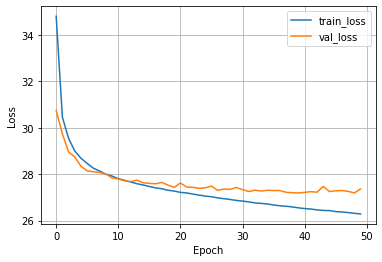

In [24]:
plot_loss(cvae_history)

از قطعه کد زیر به منظور ایجاد تصاویر بعد از هر 10 ایپاک استفاده شده است. به کمک این قطعه کد می توان روند تکامل عکس ها را مشاهده نمود.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


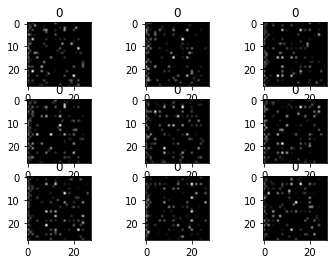

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 112us/sample - loss: 55.6839 - val_loss: 52.5587
Epoch 2/10
48000/48000 [==============================] - 5s 105us/sample - loss: 51.5076 - val_loss: 44.8255
Epoch 3/10
48000/48000 [==============================] - 5s 105us/sample - loss: 44.7232 - val_loss: 43.9940
Epoch 4/10
48000/48000 [==============================] - 5s 106us/sample - loss: 44.2950 - val_loss: 43.7779
Epoch 5/10
48000/48000 [==============================] - 5s 105us/sample - loss: 44.0276 - val_loss: 43.6230
Epoch 6/10
48000/48000 [==============================] - 5s 106us/sample - loss: 43.8508 - val_loss: 43.3845
Epoch 7/10
48000/48000 [==============================] - 5s 106us/sample - loss: 43.7207 - val_loss: 43.3010
Epoch 8/10
48000/48000 [==============================] - 5s 106us/sample - loss: 36.8489 - val_loss: 28.2744
Epoch 9/10
48000/48000 [==============================] - 5s 106us/sam

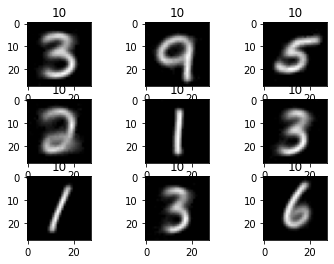

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 107us/sample - loss: 27.9359 - val_loss: 27.9298
Epoch 2/10
48000/48000 [==============================] - 5s 107us/sample - loss: 27.8452 - val_loss: 27.8513
Epoch 3/10
48000/48000 [==============================] - 5s 107us/sample - loss: 27.7638 - val_loss: 27.7652
Epoch 4/10
48000/48000 [==============================] - 5s 107us/sample - loss: 27.6888 - val_loss: 27.6273
Epoch 5/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.6323 - val_loss: 27.5895
Epoch 6/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.5650 - val_loss: 27.6323
Epoch 7/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.5165 - val_loss: 27.5641
Epoch 8/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.4589 - val_loss: 27.5326
Epoch 9/10
48000/48000 [==============================] - 5s 108us/sam

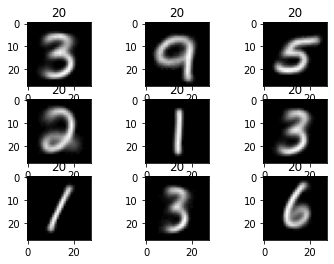

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.3283 - val_loss: 27.4644
Epoch 2/10
48000/48000 [==============================] - 5s 109us/sample - loss: 27.2739 - val_loss: 27.5009
Epoch 3/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.2401 - val_loss: 27.5317
Epoch 4/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.1985 - val_loss: 27.4156
Epoch 5/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.1718 - val_loss: 27.3842
Epoch 6/10
48000/48000 [==============================] - 5s 110us/sample - loss: 27.1260 - val_loss: 27.3837
Epoch 7/10
48000/48000 [==============================] - 5s 109us/sample - loss: 27.0858 - val_loss: 27.3604
Epoch 8/10
48000/48000 [==============================] - 5s 108us/sample - loss: 27.0650 - val_loss: 27.3998
Epoch 9/10
48000/48000 [==============================] - 5s 109us/sam

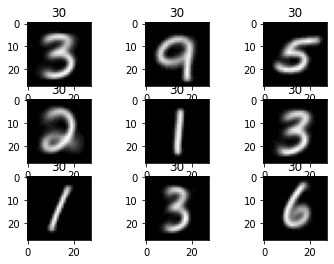

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 109us/sample - loss: 26.9644 - val_loss: 27.4304
Epoch 2/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.9312 - val_loss: 27.6932
Epoch 3/10
48000/48000 [==============================] - 5s 109us/sample - loss: 26.8973 - val_loss: 27.3716
Epoch 4/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.8730 - val_loss: 27.3051
Epoch 5/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.8466 - val_loss: 27.3688
Epoch 6/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.8224 - val_loss: 27.3263
Epoch 7/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.7900 - val_loss: 27.3596
Epoch 8/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.7484 - val_loss: 27.3317
Epoch 9/10
48000/48000 [==============================] - 5s 110us/sam

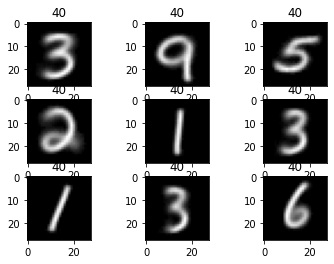

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.6903 - val_loss: 27.3111
Epoch 2/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.6488 - val_loss: 27.6968
Epoch 3/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.6276 - val_loss: 27.3145
Epoch 4/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.6074 - val_loss: 27.2884
Epoch 5/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.5768 - val_loss: 27.2739
Epoch 6/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.5630 - val_loss: 27.3289
Epoch 7/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.5293 - val_loss: 27.3058
Epoch 8/10
48000/48000 [==============================] - 5s 110us/sample - loss: 26.5025 - val_loss: 27.3653
Epoch 9/10
48000/48000 [==============================] - 5s 111us/sam

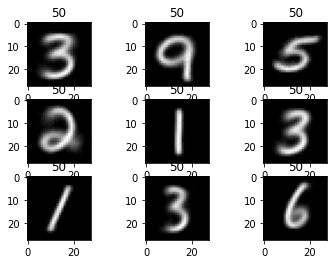

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 112us/sample - loss: 26.4370 - val_loss: 27.3374
Epoch 2/10
48000/48000 [==============================] - 5s 112us/sample - loss: 26.4169 - val_loss: 27.4140
Epoch 3/10
48000/48000 [==============================] - 5s 112us/sample - loss: 26.3954 - val_loss: 27.3746
Epoch 4/10
48000/48000 [==============================] - 5s 113us/sample - loss: 26.3710 - val_loss: 27.7340
Epoch 5/10
48000/48000 [==============================] - 5s 113us/sample - loss: 26.3395 - val_loss: 27.2763
Epoch 6/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.3215 - val_loss: 27.4190
Epoch 7/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.2973 - val_loss: 27.3446
Epoch 8/10
48000/48000 [==============================] - 5s 111us/sample - loss: 26.2799 - val_loss: 27.2523
Epoch 9/10
48000/48000 [==============================] - 5s 110us/sam

In [22]:
for j in range(6):
  output = cvae.predict([x_test, y_test])
  for i in range(9):
    plt.subplot(331+i)
    outt = output[i+500]
    op_image = np.reshape(outt*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.title(j*10)
  plt.show()
  histoy = cvae.fit([x_train,y_train], x_train, epochs=10, batch_size=64, validation_split = 0.2) # استفاده از این بخش برای ترسیم خروجی دیکودر در هر 10 ایپاک

## Scatter plot

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


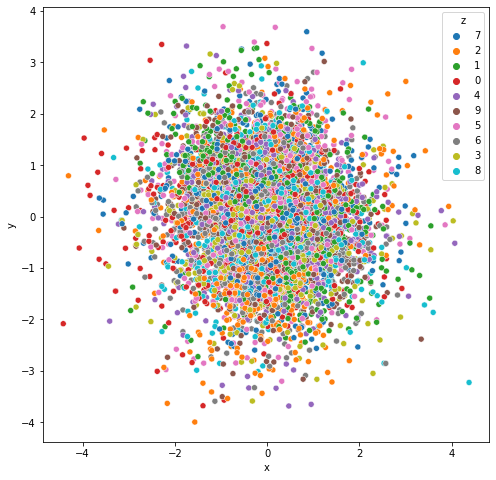

In [25]:
import pandas as pd
import seaborn as sns
latent_space = encoder_network.predict([x_test, y_test])  
latent_space = latent_space.reshape(x_test.shape[0], 2)
x = latent_space[:, 0]
y = latent_space[:, 1]
z_z = []
for i in range(100*100):
  z_z.append(y_test2[i]) #Real number coressponding to the input
zz = []
for j in z_z:
  zz.append(str(j))
datam = pd.DataFrame()
datam['x'] = x
datam['y'] = y
datam['z'] = zz
plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', hue='z', data=datam)
plt.show()

## Network Output

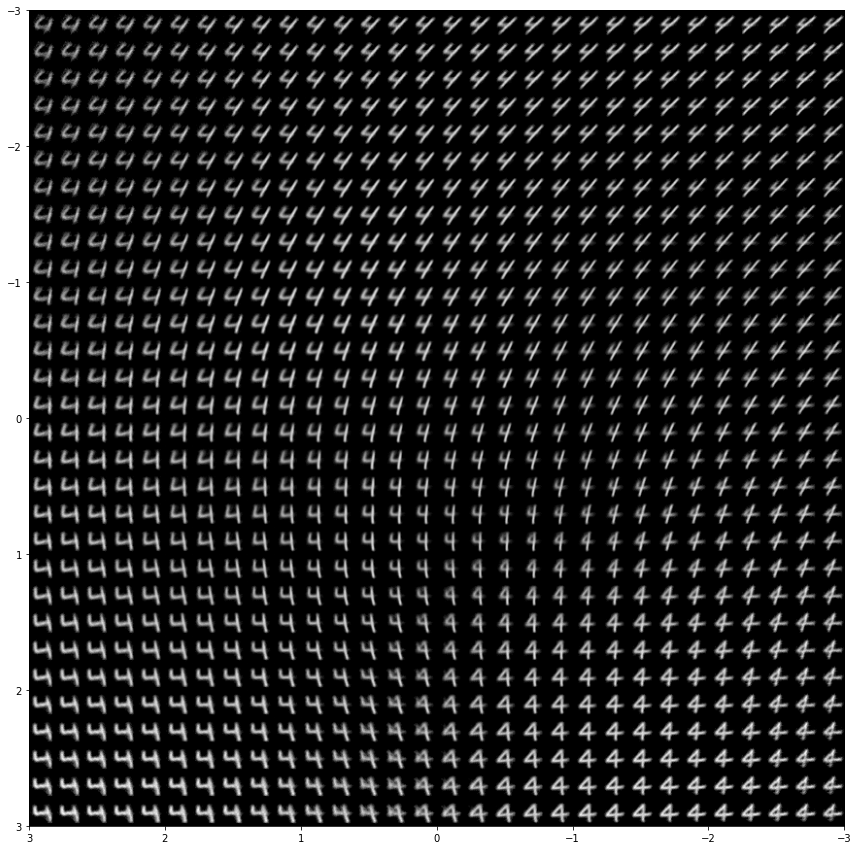

In [ ]:
number = 4
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)
finalimg = np.zeros((28 * 30, 28 * 30))
c = np.zeros(12)
c[2+number] =1 
for ix in range(len(x_values)):
  for iy in range(len(y_values)):
    latent_point = np.array([x_values[ix], y_values[iy]])
    for jj in range(len(latent_point)):
      c[jj] = latent_point[jj]
    network_out = decoder_network.predict(np.array([c]))[0]
    finalimg[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = network_out[:,:,-1]
plt.figure(figsize=(15, 15))
plt.imshow(finalimg, cmap='gray', extent=[3,-3,3,-3])
plt.show()